Student ID: 20185163 \
Name: 전효건(Hyogeon Jeon)

In [48]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
from functools import partial
from sklearn.model_selection import \
(cross_validate , KFold , ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from statsmodels.stats.anova import anova_lm

# Q5

In [119]:
Wage = load_data('Wage')

In [120]:
age = Wage['age']
y = Wage['wage']

## (a)

In [5]:
## using cross validation to select the optimal degree

CV_scores = []
H = np.array(age)
age_model = sklearn_sm(sm.OLS)
for d in range(1, 11):
    tem = np.power.outer(H, np.arange(d+1))
    cv_score = cross_validate(age_model, tem, y, cv=Wage.shape[0])
    CV_scores.append(np.mean(cv_score['test_score']))
CV_scores

[1676.234884587656,
 1600.529272922958,
 1595.9595683995444,
 1594.5958670192995,
 1594.8785607682603,
 1594.1186798533586,
 1593.7136369970558,
 1593.784940786522,
 1594.299696416935,
 1599.7755748797267]

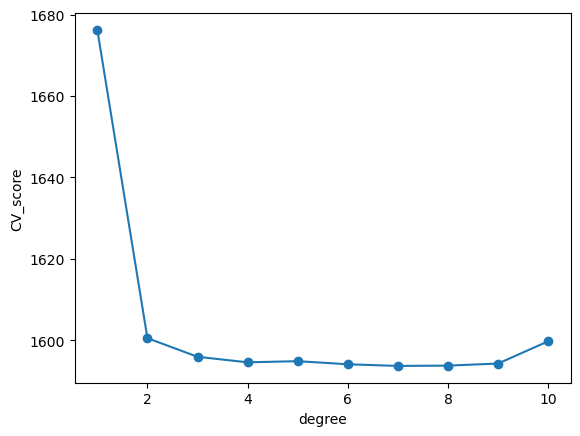

In [6]:
plt.scatter([degree for degree in range(1, 11)], CV_scores)
plt.plot([degree for degree in range(1, 11)], CV_scores)
plt.xlabel('degree')
plt.ylabel('CV_score')
plt.show()

Optimal degree d is 4.

In [7]:
## the results of hypothesis testing using ANOVA
models = [MS([poly('age', degree=d)]) for d in range(1, 11)]
XEs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.763809,2.177738e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.900512,1.668545e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.814342,5.090855e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805933,3.693976e-01
5,2993.0,4.766389e+06,1.0,3932.257665,2.470939,1.160743e-01
6,2992.0,4.763834e+06,1.0,2555.281281,1.605679,2.051988e-01
7,2991.0,4.763707e+06,1.0,126.668985,0.079596,7.778654e-01
8,2990.0,4.756703e+06,1.0,7004.317139,4.401350,3.599422e-02
9,2989.0,4.756701e+06,1.0,2.637537,0.001657,9.675292e-01


ANOVA has same optimal degree 4.

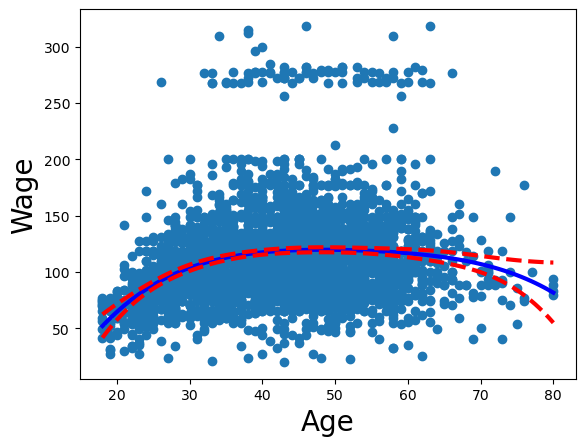

In [8]:
## Fit the model with optimal degree
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

poly_age = MS([poly('age', degree=4)]).fit(Wage) 
M = sm.OLS(y, poly_age.transform(Wage)).fit()

## Make a plot
Xnew = poly_age.transform(age_df)
y_pred = M.get_prediction(Xnew)
bands = y_pred.conf_int(alpha=0.05)

plt.scatter(age, y)
for val, ls in zip([y_pred.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
    plt.plot(age_df.values, val, ls, linewidth=3) 
 
plt.xlabel('Age', fontsize=20) 
plt.ylabel('Wage', fontsize=20)
plt.show()

## (b)

In [58]:
## using cross validation to select the best number of cuts

CV_scores_2 = []
age_model = sklearn_sm(sm.OLS)
for d in range(1, 12):
    cutting = pd.qcut(age, d)
    san_dummies = pd.get_dummies(cutting)

    

    cv_score = cross_validate(age_model, san_dummies, y, cv=Wage.shape[0])
    CV_scores_2.append(np.mean(cv_score['test_score']))
CV_scores_2

[1741.856300564997,
 1703.725248390094,
 1660.0675160597543,
 1641.3098214294298,
 1637.7166928258694,
 1630.2769159785664,
 1623.1125314742899,
 1620.1804151252088,
 1618.3466309225669,
 1615.201968555808,
 1617.051900125101]

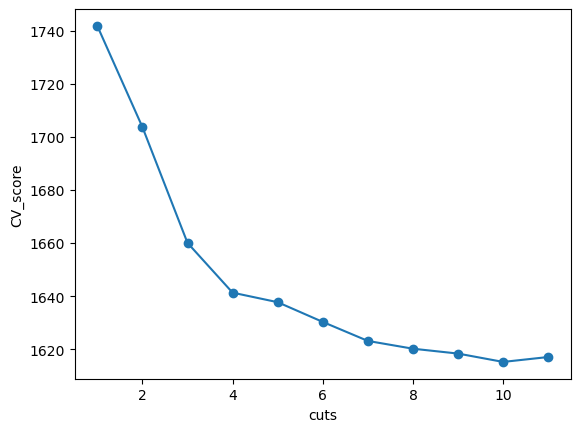

In [121]:
plt.scatter([degree for degree in range(1, 12)], CV_scores_2)
plt.plot([degree for degree in range(1, 12)], CV_scores_2)
plt.xlabel('cuts')
plt.ylabel('CV_score')
plt.show()

The optimal number of cuts: 10

In [122]:
cutting_num = 10

/var/folders/nl/dgt8hdmn7_v0m0qwx5kv3sx40000gn/T/ipykernel_10045/2547345229.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reg = sm.GLM(y_step[:,np.newaxis], X_step).fit()


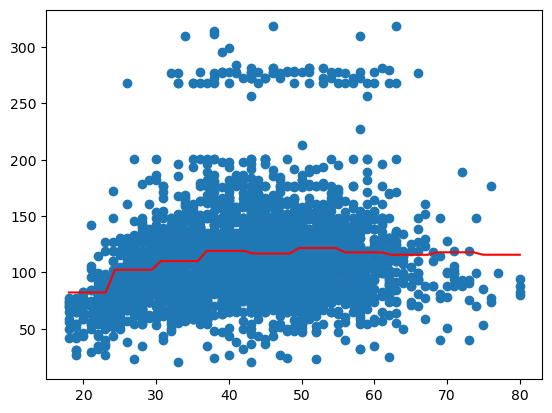

In [ ]:
age_groups = pd.qcut(age, cutting_num)
age_dummies = pd.get_dummies(age_groups)

step_data = age_dummies.join(y)

X_step = step_data.iloc[:,:-1]
y_step = step_data.iloc[:,-1]

reg = sm.GLM(y_step[:,np.newaxis], X_step).fit()

X_aux = np.linspace(age.min(),age.max())
groups_aux = pd.qcut(X_aux, cutting_num)
aux_dummies = pd.get_dummies(groups_aux)

X_step_lin = np.linspace(18,80)
y_pred = reg.predict(aux_dummies)

plt.scatter(age,y)
plt.plot(X_step_lin, y_pred,'-r')


# Q6

In [13]:
from ISLP.models import bs

In [14]:
Boston = load_data('Boston')
dis = Boston['dis']
nox = Boston['nox']

## (a)

In [15]:
## RSS by changing a range of degrees of freedom
RSS = []
for d in range(3, 17):
    bs_dis = MS([bs('dis', df=d)]).fit(Boston) 
    Xbs0 = bs_dis.transform(Boston)
    M = sm.OLS(nox, Xbs0).fit()
    rss = sum((M.resid) ** 2)
    RSS.append(rss)
RSS

[1.9341067071790692,
 1.922774992811926,
 1.8401728014885246,
 1.83396590316021,
 1.8298844459232837,
 1.8169950567252333,
 1.8256525103870551,
 1.7925348895561344,
 1.796991821731426,
 1.7889991452888836,
 1.7823504287434357,
 1.7818380568631234,
 1.7827978404413125,
 1.783545766301766]

RSS decreases until 14 and then slightly increases.

In [16]:
## Fit a regression spline using the best degrees of freedom
bs_dis = MS([bs('dis', df=14)]).fit(Boston) 
Xbs0 = bs_dis.transform(Boston)
M = sm.OLS(nox, Xbs0).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.6537,0.033,19.933,0.000
"bs(dis, df=14)[0]",0.0284,0.062,0.454,0.650
"bs(dis, df=14)[1]",0.0981,0.039,2.514,0.012
"bs(dis, df=14)[2]",0.0266,0.041,0.657,0.512
"bs(dis, df=14)[3]",-0.0268,0.036,-0.735,0.462
"bs(dis, df=14)[4]",-0.0254,0.038,-0.664,0.507
"bs(dis, df=14)[5]",-0.0710,0.038,-1.868,0.062
"bs(dis, df=14)[6]",-0.1585,0.040,-4.003,0.000
"bs(dis, df=14)[7]",-0.1497,0.038,-3.945,0.000
"bs(dis, df=14)[8]",-0.1470,0.038,-3.820,0.000


## (b)

In [17]:
## cross-validation to select the best degrees of freedom
CV_scores = []
H = np.array(dis)
dis_model = sklearn_sm(sm.OLS)
for d in range(3, 17):
    bs_dis = MS([bs('dis', df=d)]).fit(Boston) 
    Xbs0 = bs_dis.transform(Boston)
    cv_score = cross_validate(dis_model, Xbs0, nox, cv=Boston.shape[0])
    CV_scores.append(np.mean(cv_score['test_score']))
CV_scores

[0.0038747616256500214,
 0.0038930263806277593,
 0.0037042985109126663,
 0.003704597712123921,
 0.0037110988763432522,
 0.003700226732840413,
 0.003731218767662003,
 0.003693212911334346,
 0.0037152259647564166,
 0.0037009130405063033,
 0.0037081857304491635,
 0.003734087489004523,
 0.0037559728186924803,
 0.0037676287669497917]

MSE is miinimum for 10 degrees of freedom.

# Q7

In [18]:
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,log_loss) 
from sklearn.ensemble import \
(RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [19]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table 
from ISLP.models import ModelSpec as MS
from sklearn.metrics import mean_squared_error

In [20]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8, "Yes", "No")

## (a)

In [21]:
model = MS(Carseats.columns.drop('Sales'), intercept=False) 
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [22]:
## Split the data
X_train, X_test , y_train , y_test = skm.train_test_split(X, Carseats['Sales'], test_size=0.3, random_state=0)

[Text(0.5, 0.875, 'ShelveLoc[Good] <= 0.5\nsquared_error = 8.438\nsamples = 280\nvalue = 7.378'),
 Text(0.25, 0.625, 'ShelveLoc[Medium] <= 0.5\nsquared_error = 6.26\nsamples = 226\nvalue = 6.705'),
 Text(0.125, 0.375, 'Price <= 102.5\nsquared_error = 5.251\nsamples = 71\nvalue = 5.159'),
 Text(0.0625, 0.125, 'squared_error = 4.795\nsamples = 21\nvalue = 6.697'),
 Text(0.1875, 0.125, 'squared_error = 4.031\nsamples = 50\nvalue = 4.512'),
 Text(0.375, 0.375, 'Price <= 106.5\nsquared_error = 5.127\nsamples = 155\nvalue = 7.413'),
 Text(0.3125, 0.125, 'squared_error = 4.149\nsamples = 55\nvalue = 8.743'),
 Text(0.4375, 0.125, 'squared_error = 4.156\nsamples = 100\nvalue = 6.681'),
 Text(0.75, 0.625, 'Price <= 107.5\nsquared_error = 7.698\nsamples = 54\nvalue = 10.198'),
 Text(0.625, 0.375, 'Age <= 55.5\nsquared_error = 3.888\nsamples = 20\nvalue = 12.345'),
 Text(0.5625, 0.125, 'squared_error = 2.928\nsamples = 11\nvalue = 13.395'),
 Text(0.6875, 0.125, 'squared_error = 2.068\nsamples = 9\

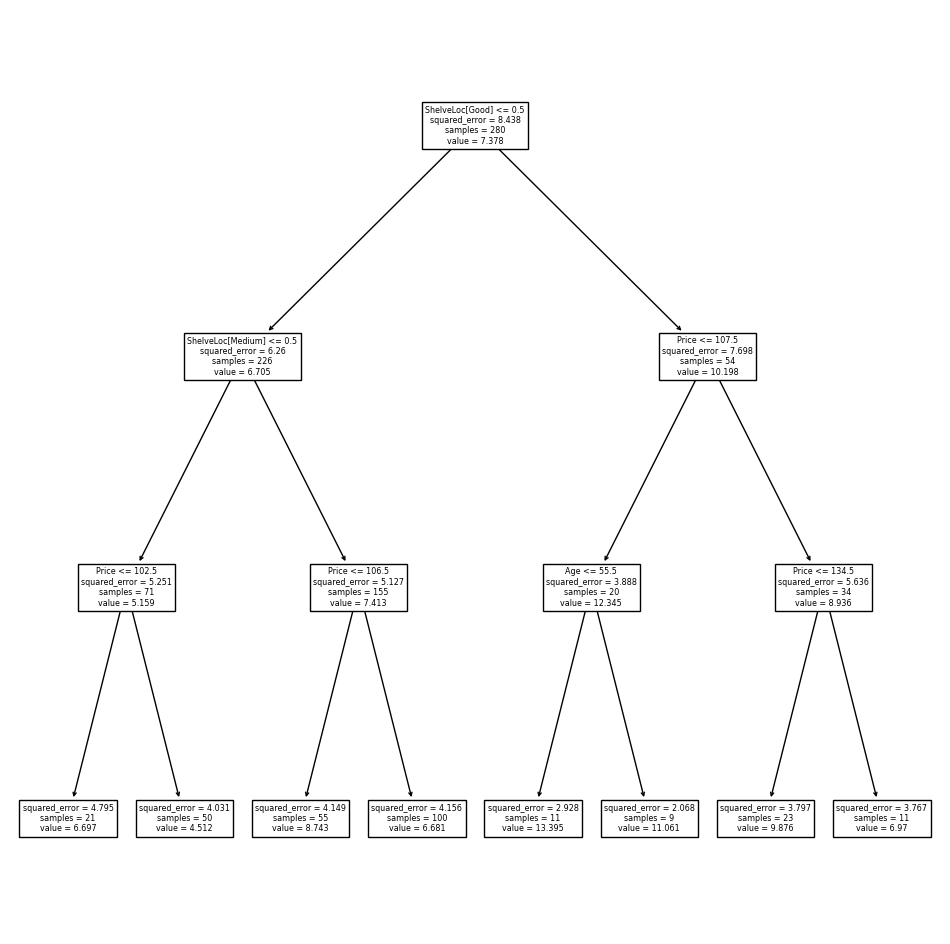

In [23]:
## Fit a regression tree && Plot the tree
reg = DTR(max_depth=3) 
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1] 
plot_tree(reg, feature_names=feature_names, ax=ax)

According to the tree, ShelveLoc is the most important factor. Price is the second most important factor.

In [24]:
## Test MSE
print('Test MSE: ', mean_squared_error(y_test, reg.predict(X_test)))

Test MSE:  3.7038582752360933


## (b)

In [25]:
## use the cross-validation function to see whether pruning the tree will improve performance

ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
kfold = skm.KFold(5, shuffle=True, random_state=10) 
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, \
                        refit=True, cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [26]:
best_ = grid.best_estimator_
print('Test MSE: ', np.mean((y_test - best_.predict(X_test))**2))

Test MSE:  3.703858275236093


It has similar MSE thus pruning the tree does not improve.

## (c)

In [27]:
## bagging approach
bag_carseat = RF(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(X_train, y_train) 
y_hat_bag = bag_carseat.predict(X_test)
print('Test MSE: ', np.mean((y_test - y_hat_bag)**2))

Test MSE:  2.022357787630009


In [28]:
feature_imp = pd.DataFrame( {'importance':bag_carseat.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.286739
ShelveLoc[Good],0.220032
Age,0.105334
CompPrice,0.100722
ShelveLoc[Medium],0.085106
Advertising,0.068797
Income,0.053542
Population,0.039245
Education,0.029526
US[Yes],0.006573


## (d)

In [29]:
## random forests
RF_carseat = RF(max_features=3, random_state=0).fit(X_train, y_train)
y_hat_RF = RF_carseat.predict(X_test) 
print('Test MSE: ', np.mean((y_test - y_hat_RF)**2))

Test MSE:  2.3081906261666654


In [30]:
feature_imp = pd.DataFrame( {'importance':RF_carseat.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.251774
ShelveLoc[Good],0.151880
Age,0.123050
CompPrice,0.094249
Advertising,0.093043
Income,0.088340
Population,0.070033
Education,0.049216
ShelveLoc[Medium],0.045724
US[Yes],0.019114


# Q8

## (a)

In [31]:
## Drop NaN rows
Hitters = load_data('Hitters')
Hitters = Hitters.dropna(subset='Salary')

Hitters = Hitters.drop(['League'], axis=1)
Hitters = Hitters.drop(['Division'], axis=1)
Hitters = Hitters.drop(['NewLeague'], axis=1)

X = Hitters.drop(['Salary'], axis=1)
y = Hitters['Salary']
## log transform
y = np.log(y)

## train, test data
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]

In [32]:
lam = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
MSE = []
for i in lam:
    boost_hitter = GBR(n_estimators=5000, learning_rate=i, max_depth=3, random_state=0)
    boost_hitter.fit(X_train, y_train)
    MSE.append(mean_squared_error(y_train, boost_hitter.predict(X_train)))

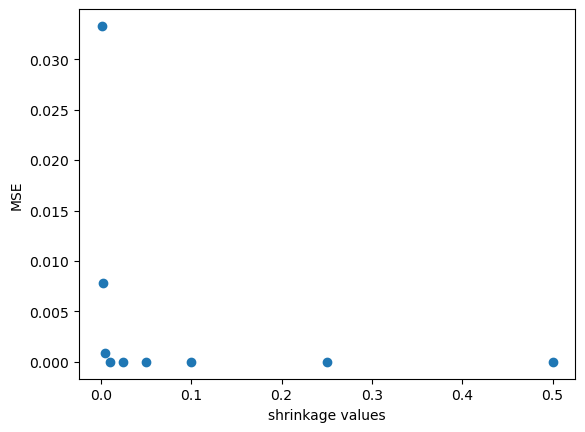

In [33]:
plt.scatter(lam, MSE)
plt.xlabel('shrinkage values')
plt.ylabel('MSE')
plt.show()

In [34]:
lam = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
MSE = []
for i in lam:
    boost_hitter = GBR(n_estimators=5000, learning_rate=i, max_depth=3, random_state=0)
    boost_hitter.fit(X_train, y_train)
    MSE.append(mean_squared_error(y_test, boost_hitter.predict(X_test)))

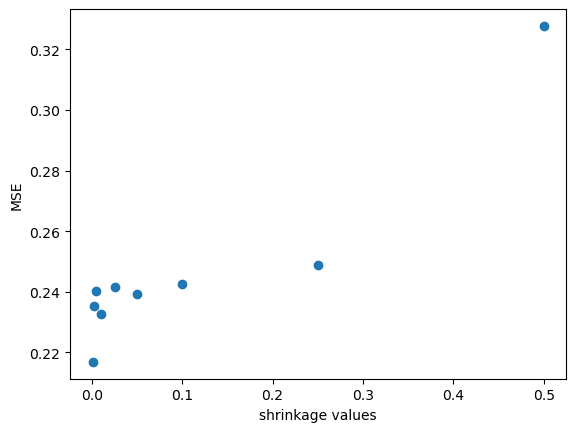

In [35]:
plt.scatter(lam, MSE)
plt.xlabel('shrinkage values')
plt.ylabel('MSE')
plt.show()

## (b)

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [37]:
print('Test MSE of boosting', np.mean(MSE))

Test MSE of boosting 0.24722959590606683


In [38]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

print('Test MSE of linear regression: ', mean_squared_error(y_test, linear_reg.predict(X_test)))

Test MSE of linear regression:  0.5156972276434895


In [39]:
ridge = RidgeCV()
ridge.fit(X_train, y_train)

print('Test MSE of ridge: ', mean_squared_error(y_test, ridge.predict(X_test)))

Test MSE of ridge:  0.5153295271239651


Boosting has better MSE than linear and ridge regression.

## (c)

In [40]:
boost_hitter = GBR(n_estimators=5000, learning_rate=0.005, max_depth=3, random_state=0)
boost_hitter.fit(X_train, y_train)
feature = [i for i in X]
feature_imp = pd.DataFrame( {'importance':boost_hitter.feature_importances_}, index=feature)
feature_imp.sort_values(by='importance', ascending=False)

,importance
CAtBat,0.525174
CHits,0.091982
CRuns,0.054053
Walks,0.048465
AtBat,0.047964
CRBI,0.036839
CHmRun,0.035570
CWalks,0.034908
Years,0.028848
Hits,0.026961
